This notebook serves purpose to explore the dataset for a Fraud Detection Algorithm. 
Here we will explore how the data is behaving, how data will lead us to predict wether a transaction is fraudulent or not. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from scipy.stats import norm 

In [2]:
credit_cards = pd.read_csv("creditcard.csv")
credit_cards.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
print(f"Fraud Cases: {(credit_cards[credit_cards["Class"] == 1].shape[0]/credit_cards.shape[0])*100:.2f}%")

Fraud Cases: 0.17%


Right so here we can see several things: 
First, we can see that the dataset is highly imbalanced. 
Secondly, all variables are standarized (as they were the result of a PCA reduction), except for Time and Amount. 

Here we will create a simple plot of box-plots for each variable separated by class (our target variable), trying to get a preliminar look to see if there are any remarkable differences in between classes. 

In [3]:
def separate_dataset_by_class(data):
    """
    This function takes a dataset with n number of columns which one of them is named Class.
    The function retruns a list of datasets separated by Class values
    """
    output = []

    for val in data["Class"].unique():
        filtered = data[data["Class"] == val]
        output.append(filtered)
    return output

In [4]:
# Just as test to see if it works. 
separated = separate_dataset_by_class(credit_cards)
print(f"Non-fraud Shape {separated[0].shape}\nFraud Shape {separated[1].shape}")

Non-fraud Shape (284315, 31)
Fraud Shape (492, 31)


In [9]:
def create_boxplots(df):
    # Step 1: Separate data (optional, if you need per-class operations)
    #classes = separate_dataset_by_class(df)

    # Step 2: Melt the data to long format
    melted = df.melt(id_vars='Class', var_name='Variable', value_name='Value')

    # Step 3: Set up subplots
    variables = melted['Variable'].unique()
    n_vars = len(variables)
    cols = 3  # Adjust this depending on how many per row
    rows = (n_vars + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case it's 2D

    # Step 4: Plot each variable in its own subplot
    for i, var in enumerate(variables):
        sns.boxplot(
            data=melted[melted['Variable'] == var],
            x='Class',
            y='Value',
            ax=axes[i]
        )
        axes[i].set_title(f'Boxplot of {var} by Class')

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Boxplots of Variables by Class", fontsize=16)
    plt.tight_layout()
    plt.show()

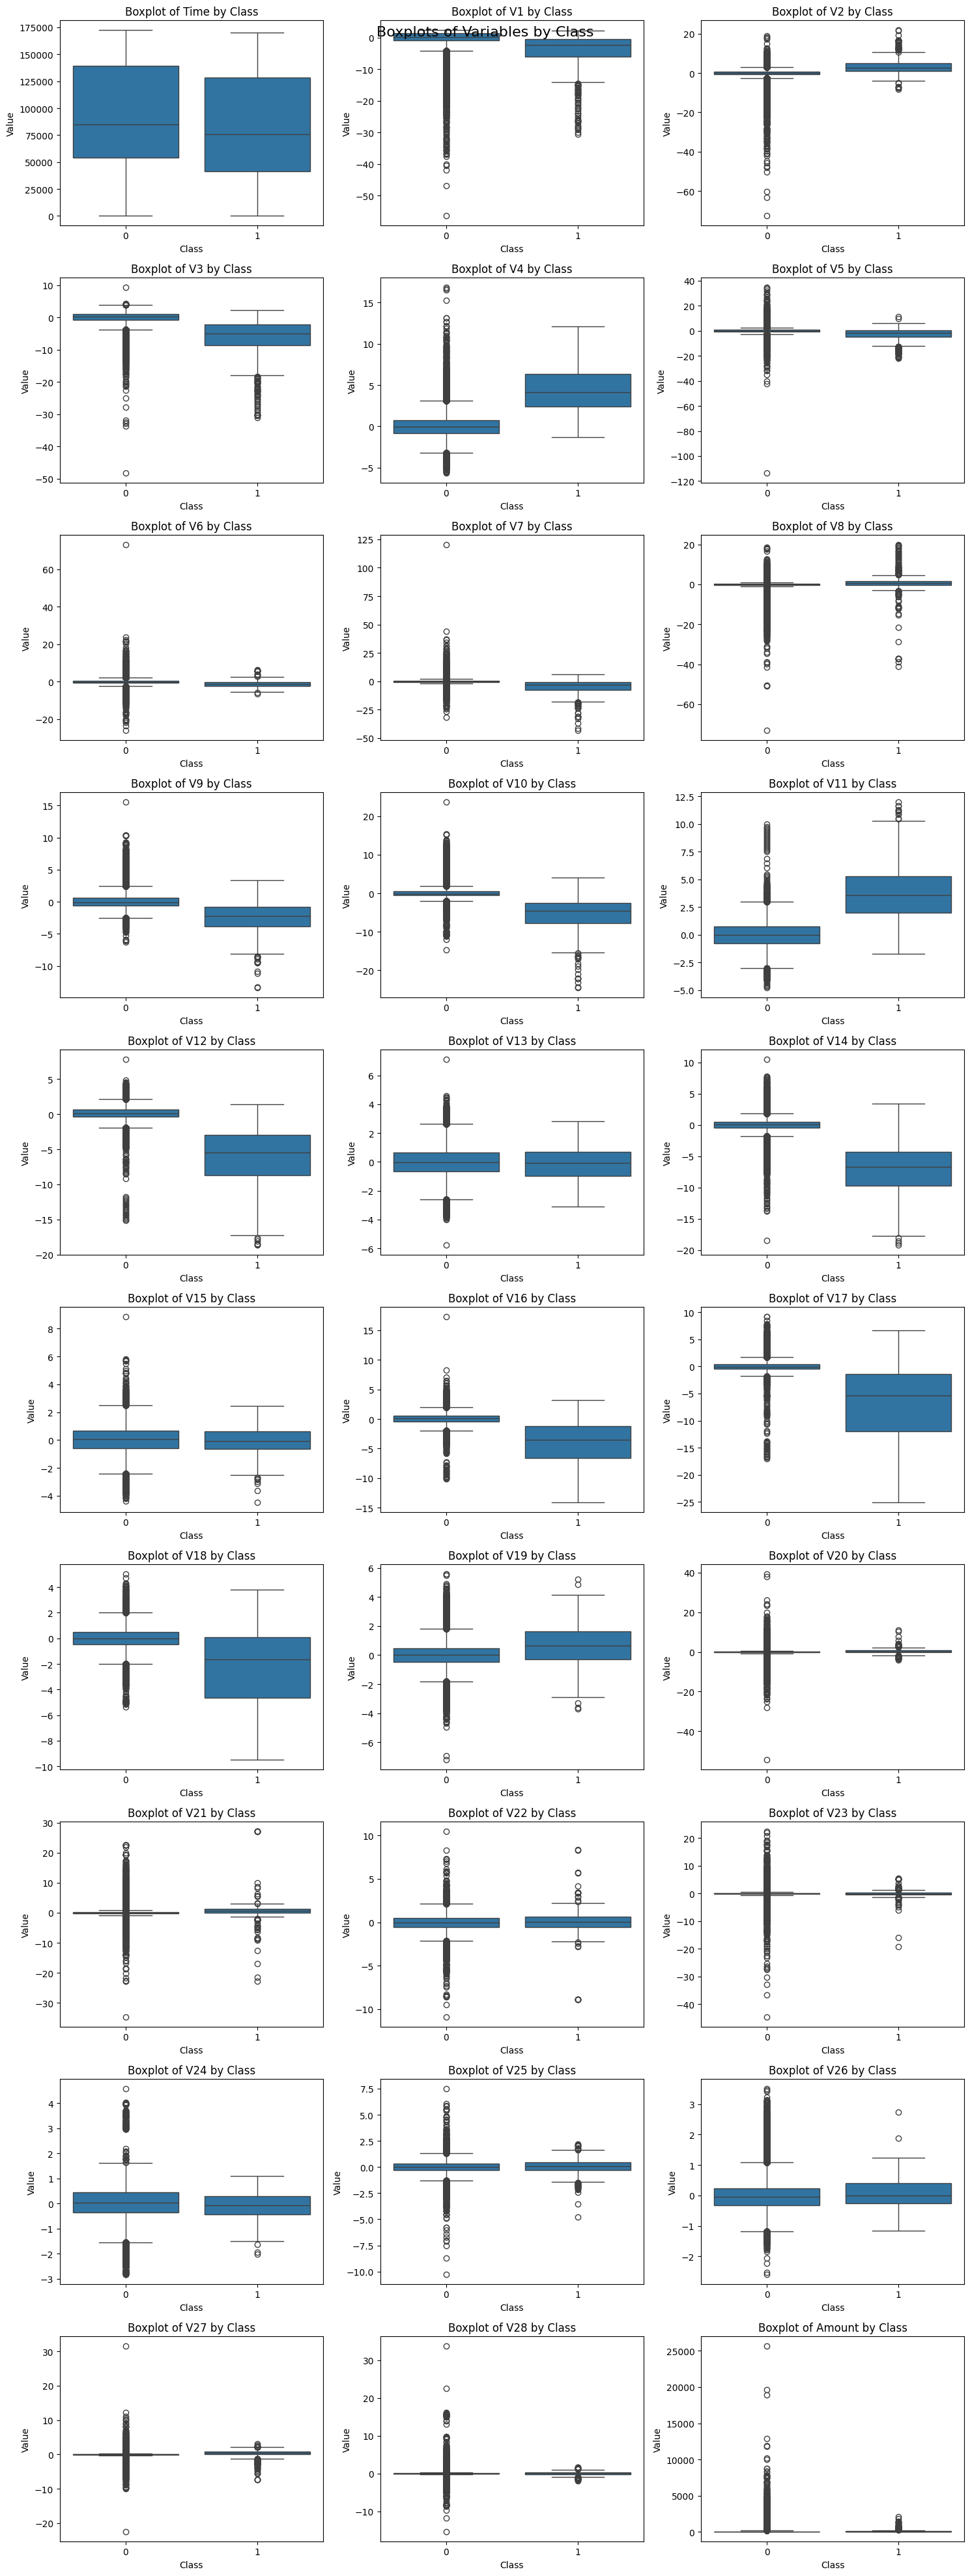

In [10]:
create_boxplots(credit_cards)

Right, so what do these boxplots tell us? Well, they mainly show two things: first, there are many outliers in most variables, which might cause some noise when training our predictive models. Secondly, this figure shows a slight yet visible difference in most of the variables, which, in essence, confirms that these variables can be used for predictive modeling towards spotting a fraudulent transaction. 

Cool. So, what is next? Well, since we are dealing with a highly imbalanced dataset, we must train our models equaly. Thus, the same amount of fraudulent transactions will be used with non-fraudulent transactions. 

In [11]:
print(f"We will create a dataframe with {separated[1].shape[0]} fraudulent transactions, and {separated[1].shape[0]} non-fraudulent transactions.")

We will create a dataframe with 492 fraudulent transactions, and 492 non-fraudulent transactions.


For this to happen, we will shuffle the non-fraudulent dataframe and take the first 492. Then, just concat both dataframes. 

In [12]:
separated[0] = separated[0].sample(frac = 1).reset_index(drop = True).iloc[:separated[1].shape[0]]
balanced_transactions = pd.concat(separated)
balanced_transactions.shape

(984, 31)

In [13]:
print(f"Fraud Cases: {(balanced_transactions[balanced_transactions["Class"] == 1].shape[0]/balanced_transactions.shape[0])*100:.2f}%")

Fraud Cases: 50.00%


Nicely done! Now that we have a balanced dataset, let's see how the boxplots look like.

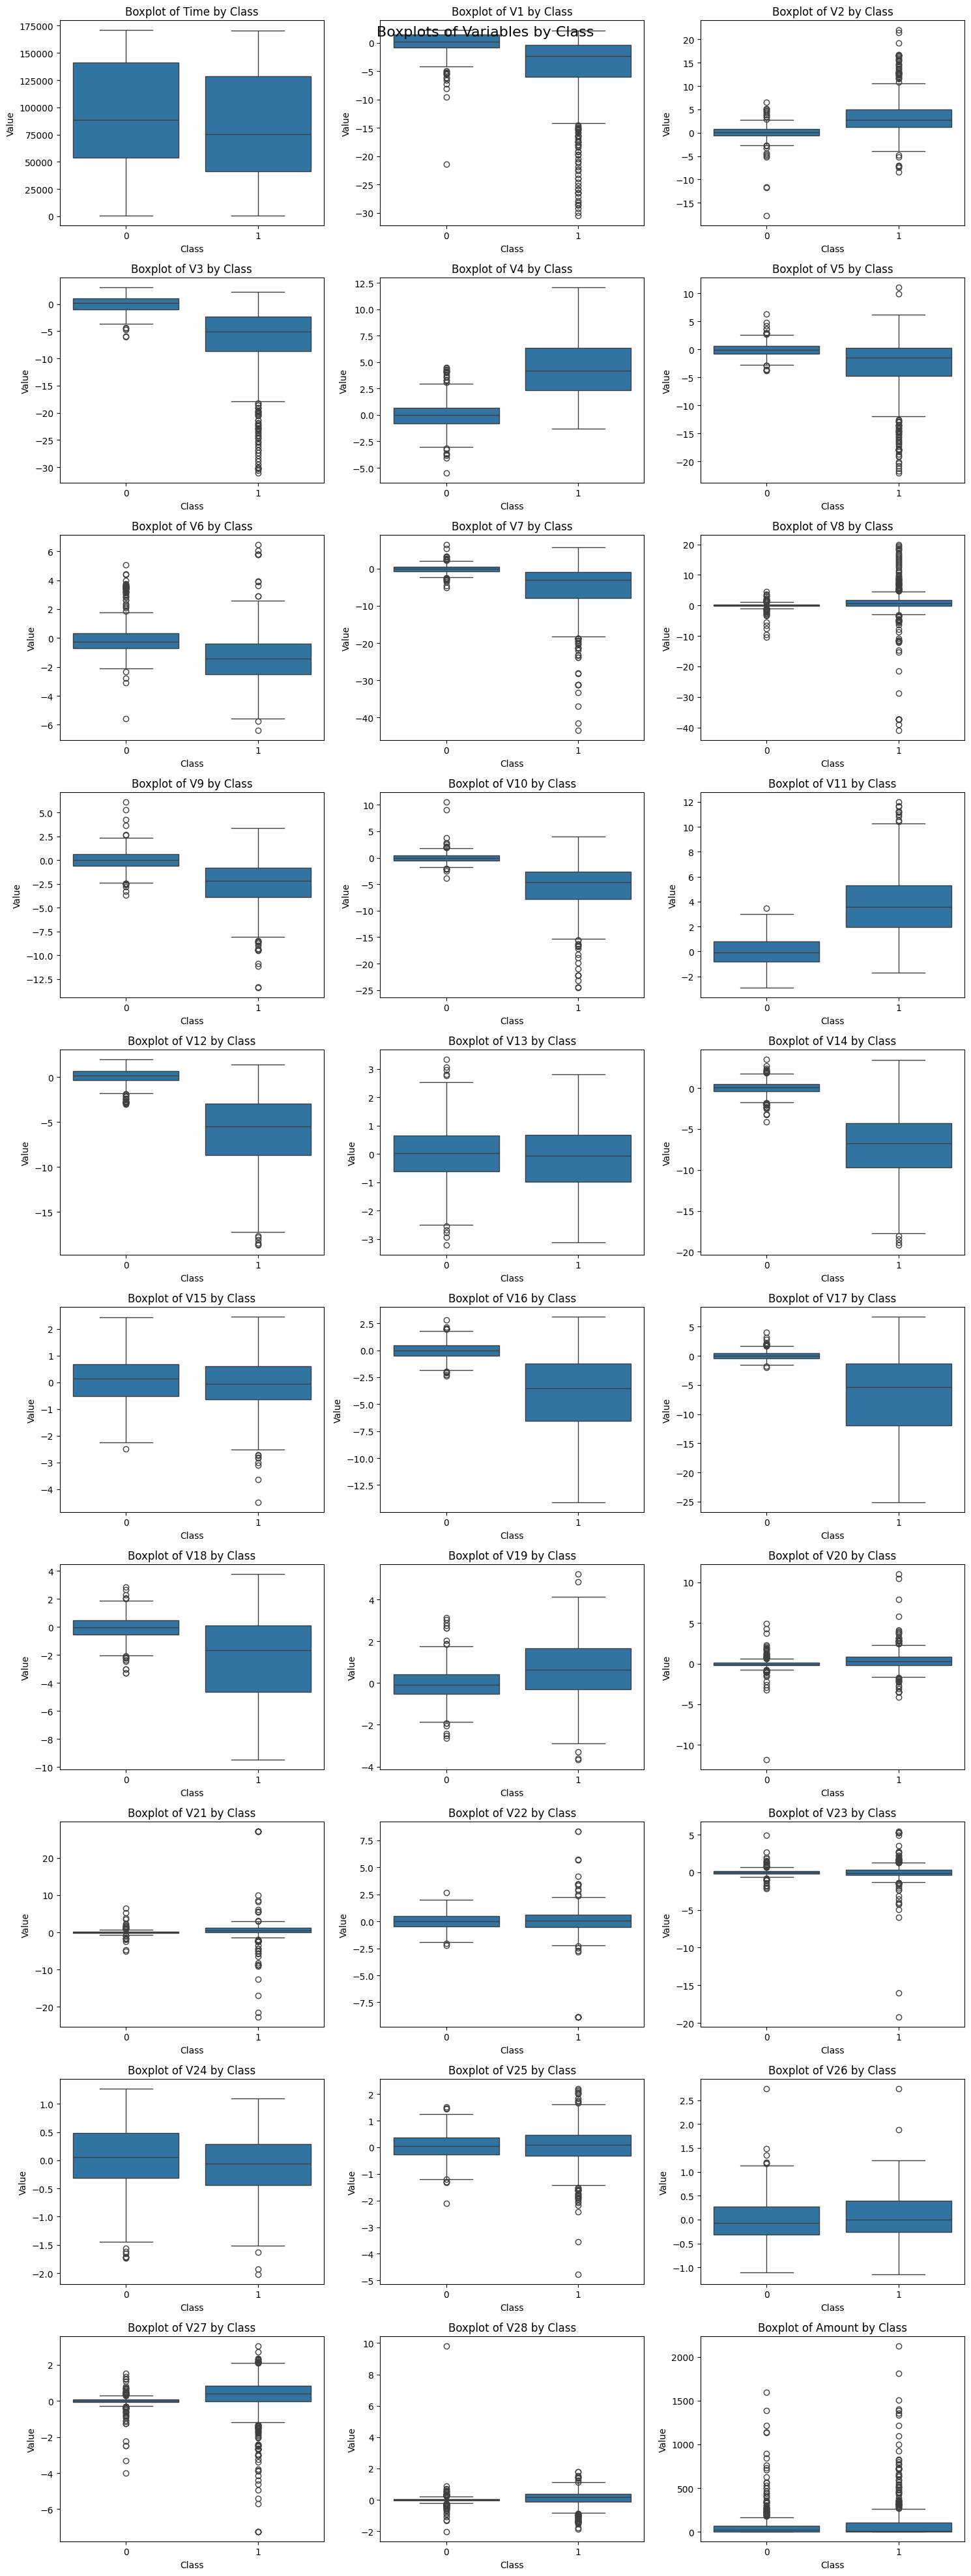

In [14]:
create_boxplots(balanced_transactions)

Is it not more clear the differences between both classes? We can work with this!

In [15]:
"""
Before we can split the data into training and testing, we might want to consider dropping outlier values.
Why? For starters, although non-fraudulent transactions seem to have more outliers, (this is just due to mere probability: 
the more individuals (transactions), the more outliers there will be) fraudlent transactions do have outlier values as well.
All this to say that, in essence, we can capture the real patterns of the data from both sets if we remove outliers. 
I like to use the 'rule of thumb' of 3 std. deviations away from the mean, but for that to be true all variables must have a normal distribution.
Thus, we will first look for a normal distribution test for variables. (we know time will not be normal, thus we can take log(time) as our new variable)

""" 

"\nBefore we can split the data into training and testing, we might want to consider dropping outlier values.\nWhy? For starters, although non-fraudulent transactions seem to have more outliers, (this is just due to mere probability: \nthe more individuals (transactions), the more outliers there will be) fraudlent transactions do have outlier values as well.\nAll this to say that, in essence, we can capture the real patterns of the data from both sets if we remove outliers. \nI like to use the 'rule of thumb' of 3 std. deviations away from the mean, but for that to be true all variables must have a normal distribution.\nThus, we will first look for a normal distribution test for variables. (we know time will not be normal, thus we can take log(time) as our new variable)\n\n"

In [16]:
# To drop outliers we will use a function that converts to a normal distribution each variable and drops outliers. 
def normalize(x, verbose=False):
    """
    Attempts to transform a pandas Series into a normally distributed form.
    Uses Shapiro-Wilk test for normality (p > 0.05 = normal).
    Tries log, Box-Cox, and Yeo-Johnson transformations.
    Returns the transformed Series.
    """
    x = x.dropna()  # remove NaNs for Shapiro
    x_array = x.values.reshape(-1, 1)  # for sklearn
    
    # If already normal, return original
    try:
        p_val = stats.shapiro(x)[1]
    except:
        if verbose: print("Shapiro failed (maybe constant values)")
        return x

    if p_val > 0.05:
        if verbose: print("Already normal")
        return x

    # Try transformations
    transforms = []

    # 1. Log
    if (x > 0).all():
        try:
            x_log = np.log(x)
            if stats.shapiro(x_log)[1] > 0.05:
                if verbose: print("Log transform worked")
                return pd.Series(x_log, index=x.index)
            transforms.append(pd.Series(x_log, index=x.index))
        except Exception as e:
            if verbose: print("Log failed:", e)

    # 2. Box-Cox
    if (x > 0).all():
        try:
            boxcox_transformed, _ = stats.boxcox(x)
            if stats.shapiro(boxcox_transformed)[1] > 0.05:
                if verbose: print("Box-Cox transform worked")
                return pd.Series(boxcox_transformed, index=x.index)
            transforms.append(pd.Series(boxcox_transformed, index=x.index))
        except Exception as e:
            if verbose: print("Box-Cox failed:", e)

    # 3. Yeo-Johnson (can handle zero and negative)
    try:
        pt = PowerTransformer(method='yeo-johnson')
        yeoj = pt.fit_transform(x_array).flatten()
        if stats.shapiro(yeoj)[1] > 0.05:
            if verbose: print("Yeo-Johnson transform worked")
            return pd.Series(yeoj, index=x.index)
        transforms.append(pd.Series(yeoj, index=x.index))
    except Exception as e:
        if verbose: print("Yeo-Johnson failed:", e)

    if verbose: print("No transform passed normality test. Returning last attempt.")
    
    return transforms[-1] if transforms else x

In [17]:
def drop_outliers(x, threshold=2):
    """
    Drops values more than `threshold` standard deviations away from the mean.
    Default is 2 std dev.
    """
    mean = np.mean(x)
    std_dev = np.std(x)
    return x[np.abs(x - mean) <= threshold * std_dev]

In [40]:
def get_data():
    x = balanced_transactions.drop(columns=["Class"])
    y = balanced_transactions["Class"]

    x_0 = pd.DataFrame(index=x.index)

    for col in x.columns:

        # Step 1: Drop outliers
        col_clean = drop_outliers(x[col])

        # Step 2: Normalize
        col_normal = normalize(col_clean)
        
        # Reinsert with correct indexing (keep NaNs for now)
        x_0[col] = col_normal

    # Add back target
    x_0["Class"] = y

    # Optionally: Drop rows with any NaN introduced by outlier removal
    Clean_data = x_0.dropna().copy()
    return Clean_data

In [34]:
# Plot Correlation Matrix
def plot_corr_mat():
    clean_transactions = get_data()
    corr = clean_transactions.corr()
    mask = np.triu(np.ones_like(corr, dtype = bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


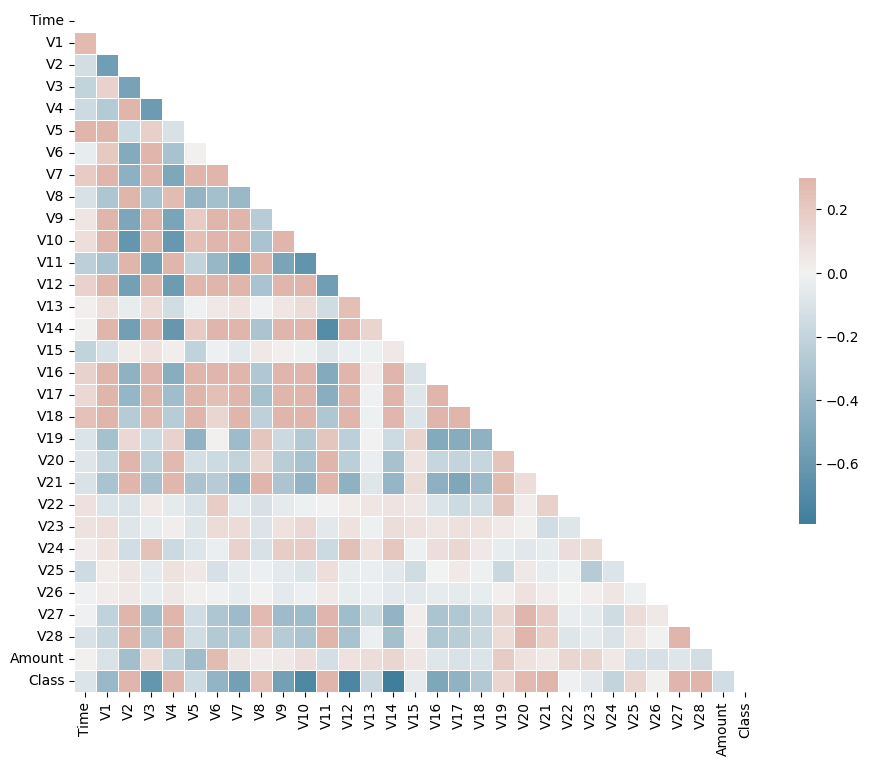

In [41]:
plot_corr_mat()

In [36]:
def plot_normal_fits(cols=None, bins=30):
    """
    Plots histograms with normal curves for all numeric columns in df.
    """
    df = get_data().drop(columns = ["Class"])
    if cols is None:
        cols = df.select_dtypes(include=np.number).columns

    n_cols = 3
    n_rows = int(np.ceil(len(cols) / n_cols))
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(cols, 1):
        plt.subplot(n_rows, n_cols, i)
        x = df[col].dropna()
        sns.histplot(x, kde=False, bins=bins, stat='density', color='lightblue')
        mu, std = x.mean(), x.std()
        xmin, xmax = plt.xlim()
        x_fit = np.linspace(xmin, xmax, 100)
        y_fit = norm.pdf(x_fit, mu, std)
        plt.plot(x_fit, y_fit, 'r--')
        plt.title(f"{col}")
        plt.xlabel("")
        plt.ylabel("Density")
    
    plt.tight_layout()
    plt.show()

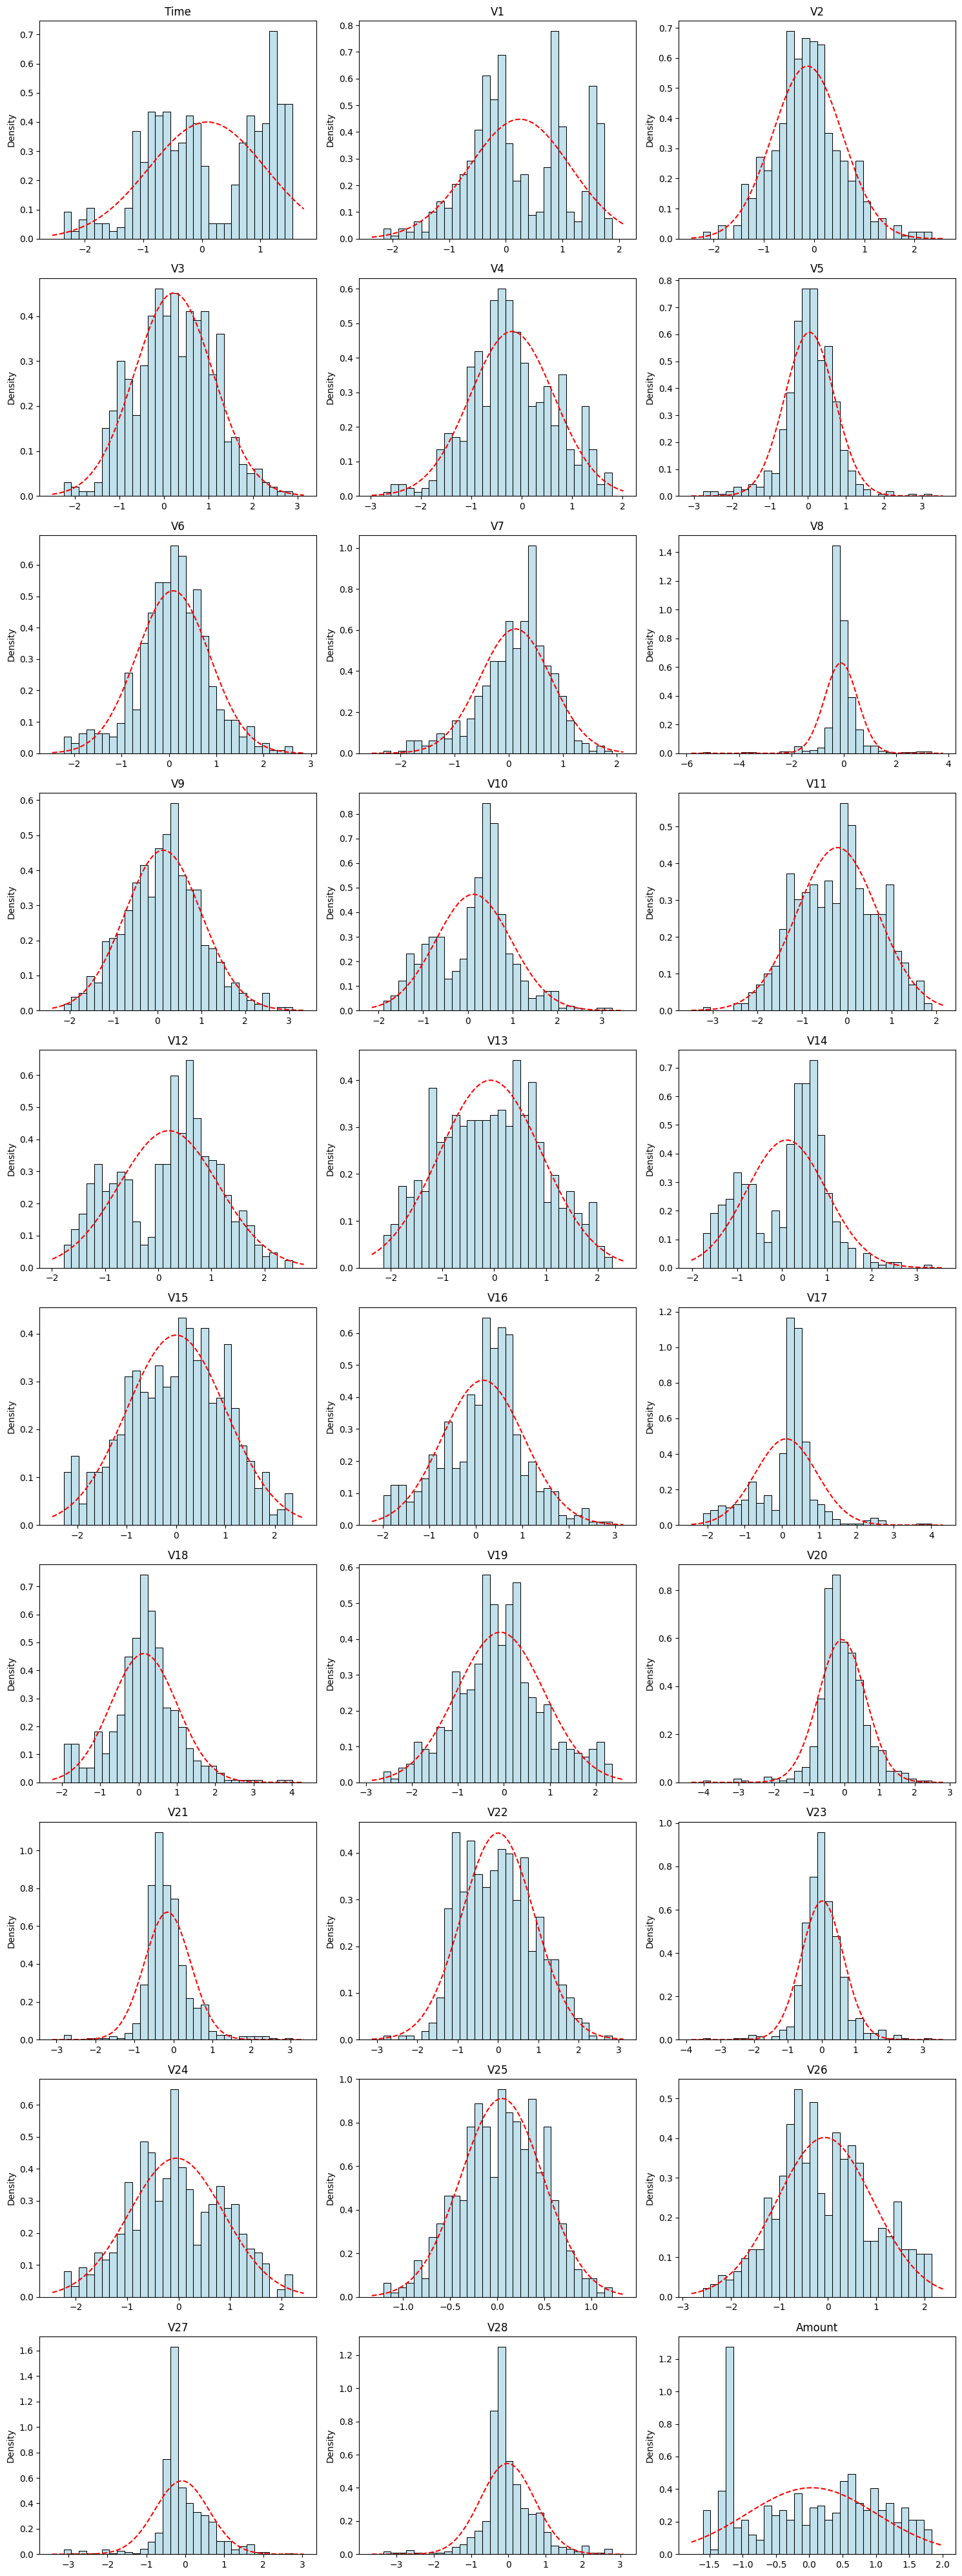

In [42]:
plot_normal_fits()

Right, so with this said and shown, our data is ready to be sent to the battlefield. 